In [1]:
# import importlib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

%matplotlib inline

import cmocean
from glob import glob
import os

from datetime import timedelta, datetime

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import pop_tools

import oae_smyle
import util

In [2]:
def get_case(region='Pacific', season='Jan', polygon=33):
    
    '''
    To generate case name, given:
        region: Pacific, Atlantic, South
        season: Jan, Apr, Jul, Oct
        polygon: polygon index, starting from 1
    '''
    
    season_to_index = {'Jan': 0, 'Apr': 1, 'Jul': 2, 'Oct': 3}
    region_to_alk_forcing_spec = {'Pacific': 'North_Pacific_basin', 'Atlantic': 'North_Atlantic_basin', 'South': 'South'}

    # get foring index in this region
    if season in season_to_index:
        forcing_id = (polygon-1) * 4 + season_to_index[season]
    else:
        raise TypeError("Input season as: Jan, Apr, Jul, Oct")

    # all forcing files
    alk_forcing_files = glob(f'/glade/scratch/mengyangz/oae-dor-global-efficiency/data/*{region}*')
    alk_forcing_files.sort()
    for i in range(len(alk_forcing_files)):
        alk_forcing_files[i] = os.path.basename(alk_forcing_files[i][:-3])

    if region in region_to_alk_forcing_spec:
        alk_forcing_spec = region_to_alk_forcing_spec[region]
    else:
        raise TypeError("Input region as: Pacific, Atlantic, South")
    alk_forcing = alk_forcing_files[forcing_id]
    case = f"smyle-fosi.{alk_forcing_spec}.{alk_forcing}"

    return case

In [3]:
%%time
case = get_case(region='Atlantic', season='Jan', polygon=0)
print(case)

ds = oae_smyle.open_dataset(case, stream='pop.h')
ds = util.process(ds)
ds_surf = ds.isel(z_t=0)

smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.149-1999-04


AssertionError: no files found.
glob string: /glade/scratch/eyankovsky/OAE-Global-Efficiency/archive/smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.149-1999-04/ocn/hist/smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.149-1999-04.pop.h.????-??.nc

In [4]:
forcing_id = 0

Read mixed layer depth

In [5]:
####### read mixed layer depth
# mld
fpath = './'
hblt_ori = xr.open_dataset(fpath + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.HBLT.030601-036812.nc')
if forcing_id%4 == 0:
    hblt_sel = hblt_ori.sel(time=slice('0347-01-01', '0361-12-01')) # cm
    mixed_layer_mask =  np.load('./mixed_layer_mask_HBLT_withfrac.npy')
elif forcing_id%4 == 1:
    hblt_sel = hblt_ori.sel(time=slice('0347-04-01', '0362-03-01')) # cm
    mixed_layer_mask =  np.load('./mixed_layer_mask_HBLT_withfrac_apr.npy')
elif forcing_id%4 == 2:
    hblt_sel = hblt_ori.sel(time=slice('0347-07-01', '0362-06-01')) # cm
    mixed_layer_mask =  np.load('./mixed_layer_mask_HBLT_withfrac_jul.npy')
elif forcing_id%4 == 3:
    hblt_sel = hblt_ori.sel(time=slice('0347-10-01', '0362-09-01')) # cm
    mixed_layer_mask =  np.load('./mixed_layer_mask_HBLT_withfrac_oct.npy')

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/u/home/eyankovsky/CWorthy/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.HBLT.030601-036812.nc'

In [6]:
# change time arrays
hblt_sel_ = hblt_sel.assign_coords({'time_delta': ds.time_delta})
hblt_sel_['time'] = ds.time

# approximate dDIC/dCO2 using carbonate ion concentration
# can replace with analytical expression
CO3_surf = ds_surf.CO3
dDICdCO2_approxi = -6.07 + 0.121 * CO3_surf # Sarmiento & Gruber (2006), Fig 8.3.4

Average after calculating Tau_gas

In [7]:
tau_gas_approxi = dDICdCO2_approxi * (hblt_sel_.HBLT*1e-2) / (ds_surf.ECOSYS_XKW*1e-2) / 86400.0 # units days
tau_gas_approxi.attrs['units'] = 'days'

In [8]:
tau_gas_approxi_mean = (tau_gas_approxi/30).isel(time=slice(0,12)).mean(dim='time')
tau_gas_approxi_mean = tau_gas_approxi_mean.compute()

In [9]:
tau_gas_approxi_mean = tau_gas_approxi_mean.to_dataset(name='tau_gas')

Average variables first

In [10]:
dDICdCO2_approxi_mean = dDICdCO2_approxi.isel(time=slice(0,12)).mean(dim='time')
hblt_sel_mean = hblt_sel_.HBLT.isel(time=slice(0,12)).mean(dim='time')
ds_surf_mean = ds_surf.ECOSYS_XKW.isel(time=slice(0,12)).mean(dim='time')

tau_gas_approxi_mean_first = dDICdCO2_approxi_mean * (hblt_sel_mean*1e-2) / (ds_surf_mean*1e-2) / 86400.0 # units days
tau_gas_approxi_mean_first.attrs['units'] = 'days'
tau_gas_approxi_mean_first = tau_gas_approxi_mean_first/30
tau_gas_approxi_mean_first = tau_gas_approxi_mean_first.to_dataset(name='tau_gas')

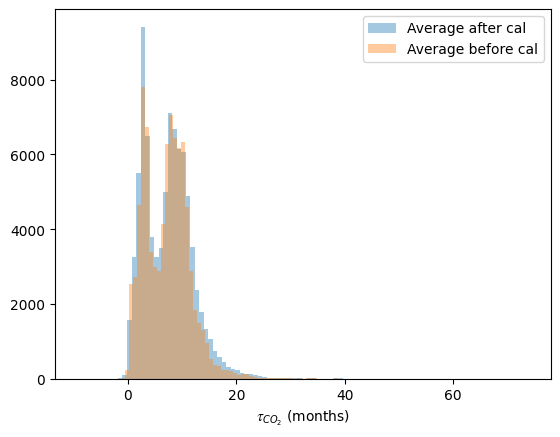

In [11]:
tau_gas_approxi_mean.tau_gas.plot.hist(bins=100, alpha=0.4, color='C0', label='Average after cal');
tau_gas_approxi_mean_first.tau_gas.plot.hist(bins=100, alpha=0.4, color='C1', label='Average before cal');
plt.title('')
plt.xlabel('$𝜏_{CO_2}$ (months)')
plt.legend()

In [12]:
tau_gas_approxi_mean_ = util.pop_add_cyclic(tau_gas_approxi_mean)
ds_ = util.pop_add_cyclic(ds)

In [13]:
tau_gas_approxi_mean_first_ = util.pop_add_cyclic(tau_gas_approxi_mean_first)

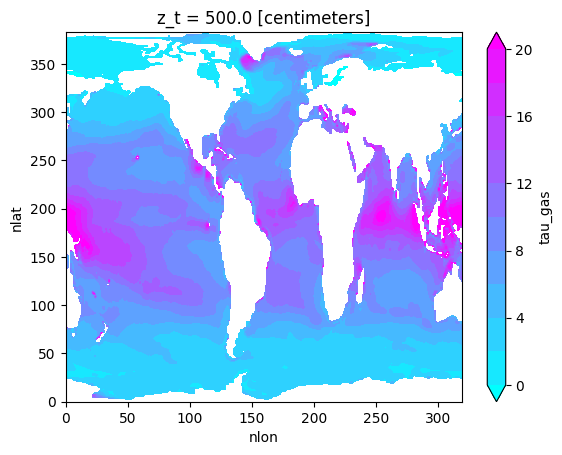

In [14]:
tau_gas_approxi_mean_.tau_gas.plot.contourf(levels=np.linspace(0,20,11), cmap=plt.cm.cool)

Text(0.5, 1.0, 'Average before cal')

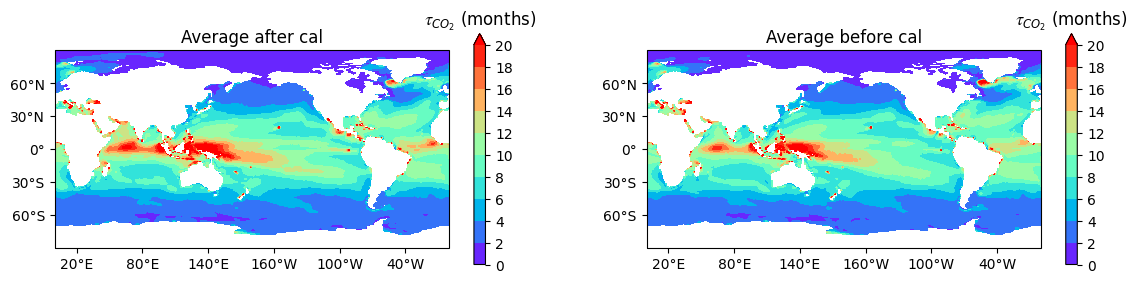

In [15]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree(central_longitude=180))
ax1 = plt.subplot(1,2,2, projection=ccrs.PlateCarree(central_longitude=180))

lon_min = 0
lon_max = 360
lat_min = -90
lat_max = 90

def modify(ax):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

    #ax.add_feature(cfeature.LAND, edgecolor='black')
    
modify(ax)
modify(ax1)

custom_colorbar_ticks = np.linspace(0,20,11)
custom_colorbar_labels  = [str(int(num)) for num in custom_colorbar_ticks]
sca = ax.contourf(ds_.TLONG, ds_.TLAT, tau_gas_approxi_mean_.tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

sca1 = ax1.contourf(ds_.TLONG, ds_.TLAT, tau_gas_approxi_mean_first_.tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

def add_cbar(sca, ax):
    cb = fig.colorbar(sca, ax=ax, shrink=0.5)
    cb.ax.set_title('$𝜏_{CO_2}$ (months)')
    cb.set_ticks(custom_colorbar_ticks)
    cb.set_ticklabels(custom_colorbar_labels)

add_cbar(sca, ax)
add_cbar(sca1, ax1)
ax.set_title('Average after cal')
ax1.set_title('Average before cal')

#tau_gas_approxi_mean.tau_gas.plot.contourf(ax=ax, levels=np.linspace(0,20,11), cmap=plt.cm.cool,transform=ccrs.PlateCarree())

## Exact calcualtion

The linear relationship between CO3 and dCO2dDIC doesn't hold when CO3 is very low

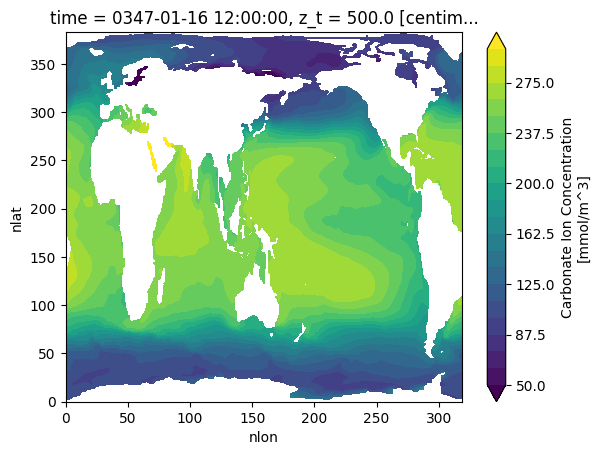

In [16]:
ds_surf.CO3.isel(time=0).plot.contourf(levels=np.linspace(50,300,21))

In [17]:
import PyCO2SYS as pyco2
from PyCO2SYS import CO2SYS

In [22]:
%%time
## dDICdCO2  with analytical expression
fpath = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
temp = xr.open_dataset(fpath + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.TEMP.030601-036812.nc') # potential temp
salt = xr.open_dataset(fpath + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.SALT.030601-036812.nc') # potential salinity
si = xr.open_dataset(fpath + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.SiO3.030601-036812.nc') # SiO3
po4 = xr.open_dataset(fpath + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.PO4.030601-036812.nc') # PO4

# find the index of first time, and select the next 15 years, to match model output with salt, temp, si....
first_time = salt.sel(time=slice(ds_surf.time.values[0], ds_surf.time.values[1])).time.values[0]
first_time_index = np.where(salt.time.values == first_time)[0][0]  # start from 0347-02-01

# Grab data and slice out just the surface layer, as a function of time
tco2 = ds_surf.DIC
talk = ds_surf.ALK
salinity = salt.SALT.isel(z_t=0, time=slice(first_time_index, first_time_index+15*12))
theta = temp.TEMP.isel(z_t=0, time=slice(first_time_index, first_time_index+15*12))
# phosphate = po4.PO4.isel(z_t=0, time=slice(first_time_index, first_time_index+15*12))
# silicate = si.SiO3.isel(z_t=0, time=slice(first_time_index, first_time_index+15*12))

# Some default properties
sal      =   np.nan  # Salinity of the sample
tempin   =   10  # Temperature at input conditions
sil      =   50  # Concentration of silicate  in the sample (in umol/kg)
po4      =    2  # Concentration of phosphate in the sample (in umol/kg)
presin   =    0  # Pressure    at input conditions
pHscale  =    1  # pH scale at which the input pH is reported ("1" means "Total Scale")
k1k2c    =    4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c    =    1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson"

# dDIC = 0.1
# csys =      CO2SYS(talk.values, tco2.values, 1, 2, salinity.values, theta.values, theta.values, 0, 0, sil, po4, pHscale, k1k2c, kso4c)
# csys_plus = CO2SYS(talk.values, tco2.values+dDIC, 1, 2, salinity.values, theta.values,  theta.values, 0, 0, sil, po4, pHscale, k1k2c, kso4c)
# dCO2 = np.array(csys_plus['CO2out']) - np.array(csys['CO2out'])
# dDICdCO2 =  dDIC/dCO2
# dDICdCO2 = dDICdCO2.reshape(tco2.shape)

# dDICdCO2.attrs['units'] = 'mol/mol'
# dDICdCO2.attrs['long_name'] = '$\partial$DIC/$\partial$CO$_2$'
# tau_gas = dDICdCO2 * (hblt_sel_.HBLT*1e-2) / (ds_surf.ECOSYS_XKW*1e-2) / 86400.0 # units days
# tau_gas.attrs['units'] = 'days'

CPU times: user 96.3 ms, sys: 5.92 ms, total: 102 ms
Wall time: 283 ms


In [24]:
def cal_dDICdCO2(talk, tco2, salinity, theta):
    
    func = lambda talk, tco2, salinity, theta: \
    CO2SYS(talk, tco2, 1, 2, salinity, theta, theta, 0, 0, sil, po4, pHscale, k1k2c, kso4c)
    
    return xr.apply_ufunc(func, talk, tco2, salinity, theta)

In [25]:
talk_mean = talk.isel(time=slice(0,12)).mean(dim='time').values
tco2_mean = tco2.isel(time=slice(0,12)).mean(dim='time').values
salinity_mean = salinity.isel(time=slice(0,12)).mean(dim='time').values
theta_mean = theta.isel(time=slice(0,12)).mean(dim='time').values

In [26]:
dDIC = 0.1
csys = cal_dDICdCO2(talk_mean, tco2_mean, salinity_mean,theta_mean)
csys_plus = cal_dDICdCO2(talk_mean, tco2_mean+dDIC, salinity_mean,theta_mean)
dCO2 = np.array(csys_plus['CO2out']) - np.array(csys['CO2out'])
dDICdCO2 =  dDIC/dCO2
dDICdCO2 = dDICdCO2.reshape(tco2_mean.shape)

# dDICdCO2.attrs['units'] = 'mol/mol'
# dDICdCO2.attrs['long_name'] = '$\partial$DIC/$\partial$CO$_2$'

In [27]:
hblt_sel_mean = hblt_sel_.HBLT.isel(time=slice(0,12)).mean(dim='time')
ds_surf_mean = ds_surf.ECOSYS_XKW.isel(time=slice(0,12)).mean(dim='time')

tau_gas_exact_mean = dDICdCO2 * (hblt_sel_mean*1e-2) / (ds_surf_mean*1e-2) / 86400.0 # units days
tau_gas_exact_mean.attrs['units'] = 'days'

In [28]:
tau_gas_exact_mean = (tau_gas_exact_mean/30).to_dataset(name='tau_gas')

In [29]:
tau_gas_exact_mean['TLAT'] = tau_gas_approxi_mean.TLAT
tau_gas_exact_mean['TLONG'] = tau_gas_approxi_mean.TLONG

MergeError: unable to determine if these variables should be coordinates or not in the merged result: {'TLAT'}

In [30]:
tau_gas_exact_mean_ = util.pop_add_cyclic(tau_gas_exact_mean)

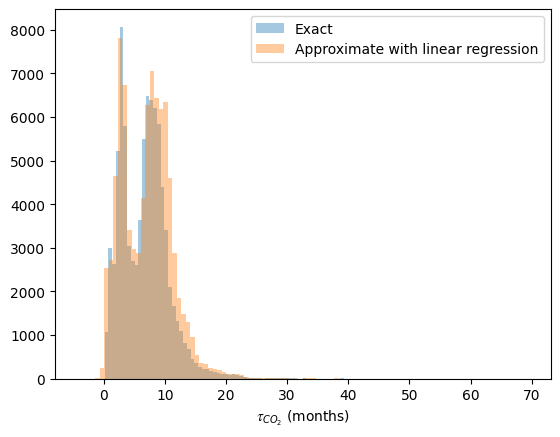

In [31]:
tau_gas_exact_mean_.tau_gas.plot.hist(bins=100, alpha=0.4, color='C0', label='Exact');
tau_gas_approxi_mean_first.tau_gas.plot.hist(bins=100, alpha=0.4, color='C1', label='Approximate with linear regression');
plt.title('')
plt.xlabel('$𝜏_{CO_2}$ (months)')
plt.legend()

Text(0.5, 1.0, 'Approximate with linear regression')

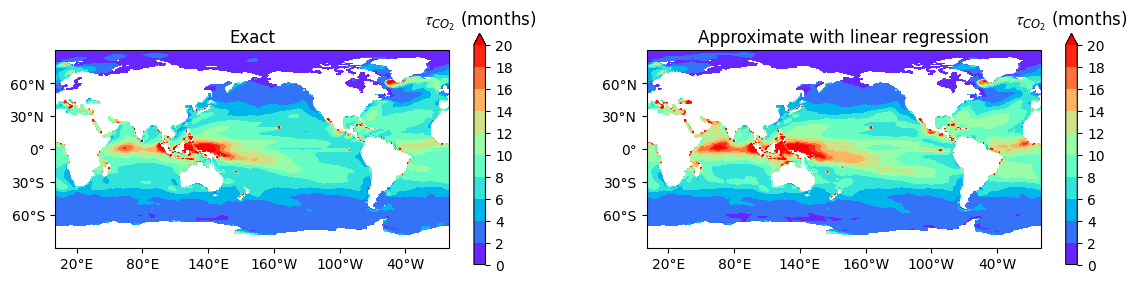

In [32]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree(central_longitude=180))
ax1 = plt.subplot(1,2,2, projection=ccrs.PlateCarree(central_longitude=180))

lon_min = 0
lon_max = 360
lat_min = -90
lat_max = 90

def modify(ax):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

    #ax.add_feature(cfeature.LAND, edgecolor='black')
    
modify(ax)
modify(ax1)

custom_colorbar_ticks = np.linspace(0,20,11)
custom_colorbar_labels  = [str(int(num)) for num in custom_colorbar_ticks]
sca = ax.contourf(ds_.TLONG, ds_.TLAT, tau_gas_exact_mean_.tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

sca1 = ax1.contourf(ds_.TLONG, ds_.TLAT, tau_gas_approxi_mean_.tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

def add_cbar(sca, ax):
    cb = fig.colorbar(sca, ax=ax, shrink=0.5)
    cb.ax.set_title('$𝜏_{CO_2}$ (months)')
    cb.set_ticks(custom_colorbar_ticks)
    cb.set_ticklabels(custom_colorbar_labels)

add_cbar(sca, ax)
add_cbar(sca1, ax1)
ax.set_title('Exact')
ax1.set_title('Approximate with linear regression')

#tau_gas_approxi_mean.tau_gas.plot.contourf(ax=ax, levels=np.linspace(0,20,11), cmap=plt.cm.cool,transform=ccrs.PlateCarree())

### CO3

In [33]:
CO3_mean = ds_surf.CO3.isel(time=slice(0,12)).mean(dim='time')
CO3_mean = CO3_mean.to_dataset(name='CO3')

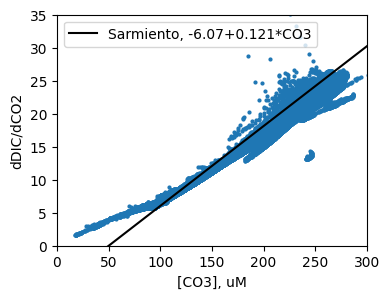

In [34]:
plt.figure(figsize=(4,3))
plt.scatter(CO3_mean.CO3, dDICdCO2, s=4)
plt.plot([0,300],[-6.07, -6.07+0.121*300], label="Sarmiento, -6.07+0.121*CO3", c="black")
plt.xlim([0,300])
plt.ylim([0,35])
plt.xlabel("[CO3], uM")
plt.ylabel("dDIC/dCO2")
plt.legend(loc="upper left")

In [35]:
CO3_mean = util.pop_add_cyclic(CO3_mean)

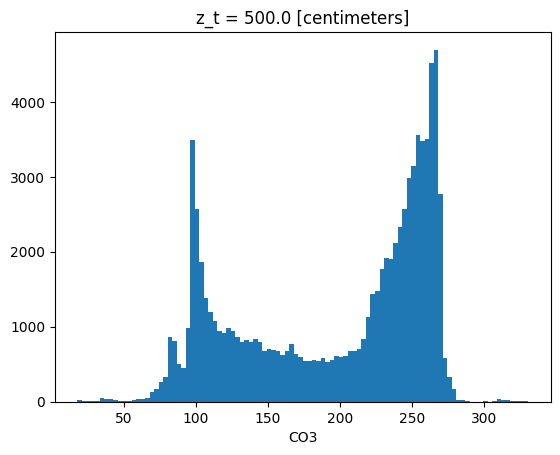

In [38]:
CO3_mean.CO3.plot.hist(bins=100);

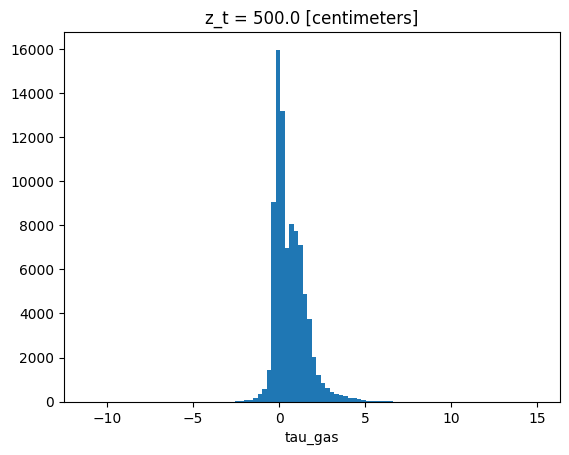

In [39]:
(-tau_gas_exact_mean_ + tau_gas_approxi_mean_).tau_gas.plot.hist(bins=100);

Text(0.5, 1.0, 'Mean surface CO3')

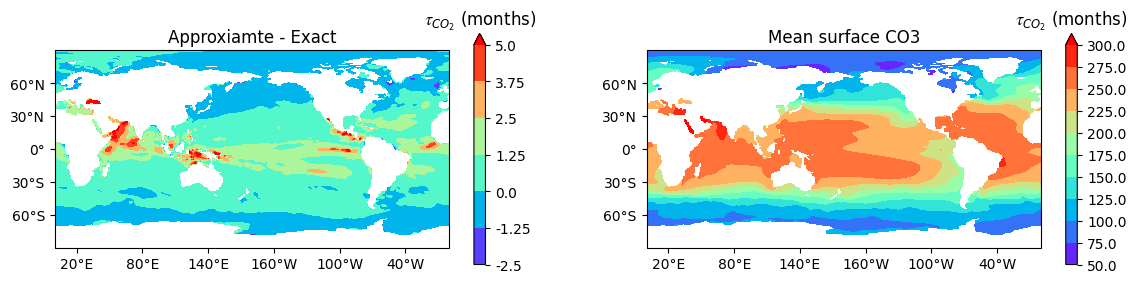

In [40]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(1,2,1, projection=ccrs.PlateCarree(central_longitude=180))
ax1 = plt.subplot(1,2,2, projection=ccrs.PlateCarree(central_longitude=180))

lon_min = 0
lon_max = 360
lat_min = -90
lat_max = 90

def modify(ax):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

    #ax.add_feature(cfeature.LAND, edgecolor='black')
    
modify(ax)
modify(ax1)

custom_colorbar_ticks = np.linspace(-2.5,5,7)
sca = ax.contourf(ds_.TLONG, ds_.TLAT, (tau_gas_approxi_mean_ - tau_gas_exact_mean_).tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

custom_colorbar_ticks1 = np.linspace(50,300,11)
sca1 = ax1.contourf(ds_.TLONG, ds_.TLAT, CO3_mean.CO3,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks1,
                  extend='max',
                 );

def add_cbar(sca, ax, custom_colorbar_ticks):
    custom_colorbar_labels  = [str(num) for num in custom_colorbar_ticks]
    cb = fig.colorbar(sca, ax=ax, shrink=0.5)
    cb.ax.set_title('$𝜏_{CO_2}$ (months)')
    cb.set_ticks(custom_colorbar_ticks)
    cb.set_ticklabels(custom_colorbar_labels)

add_cbar(sca, ax, custom_colorbar_ticks)
add_cbar(sca1, ax1, custom_colorbar_ticks1)
ax.set_title('Approxiamte - Exact')
ax1.set_title('Mean surface CO3')

#tau_gas_approxi_mean.tau_gas.plot.contourf(ax=ax, levels=np.linspace(0,20,11), cmap=plt.cm.cool,transform=ccrs.PlateCarree())

# 4 months

In [41]:
talk_smean = talk.isel(time=slice(0,12)).isel(time=[0,3,6,9]).values
tco2_smean = tco2.isel(time=slice(0,12)).isel(time=[0,3,6,9]).values
salinity_smean = salinity.isel(time=slice(0,12)).isel(time=[0,3,6,9]).values
theta_smean = theta.isel(time=slice(0,12)).isel(time=[0,3,6,9]).values

dDIC = 0.1
csys = cal_dDICdCO2(talk_smean, tco2_smean, salinity_smean, theta_smean)
csys_plus = cal_dDICdCO2(talk_smean, tco2_smean+dDIC, salinity_smean, theta_smean)
dCO2 = np.array(csys_plus['CO2out']) - np.array(csys['CO2out'])
dDICdCO2 =  dDIC/dCO2
dDICdCO2 = dDICdCO2.reshape(tco2_smean.shape)

In [42]:
hblt_sel_smean = hblt_sel_.HBLT.isel(time=slice(0,12)).isel(time=[0,3,6,9])
ds_surf_smean = ds_surf.ECOSYS_XKW.isel(time=slice(0,12)).isel(time=[0,3,6,9])

tau_gas_exact_smean = dDICdCO2 * (hblt_sel_smean*1e-2) / (ds_surf_smean*1e-2) / 86400.0 # units days
tau_gas_exact_smean.attrs['units'] = 'days'

In [43]:
tau_gas_exact_smean = (tau_gas_exact_smean/30).to_dataset(name='tau_gas')
tau_gas_exact_smean['TLAT'] = tau_gas_exact_mean.TLAT
tau_gas_exact_smean['TLONG'] = tau_gas_exact_mean.TLONG

In [44]:
tau_gas_exact_smean_ = util.pop_add_cyclic(tau_gas_exact_smean)

In [301]:
tau_gas_exact_smean_

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 321, time: 4)
Coordinates:
    z_t      float32 500.0
  * time     (time) object 0347-01-16 12:00:00 ... 0347-10-16 12:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
    TLONG    (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.29 -39.57 -39.86
    tau_gas  (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 161), meta=np.ndarray>

Text(0.5, 1.0, 'Oct')

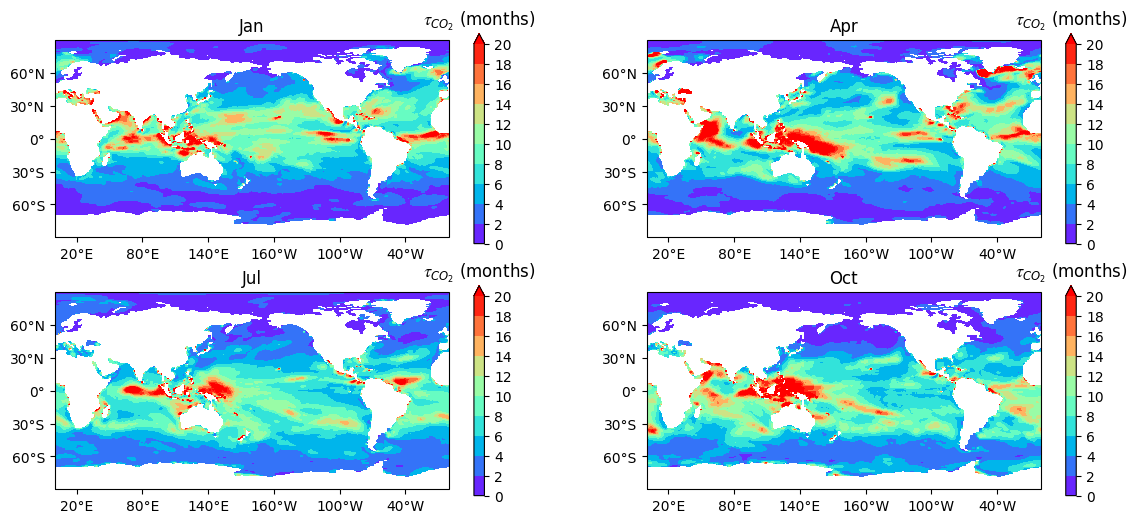

In [45]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(2,2,1, projection=ccrs.PlateCarree(central_longitude=180))
ax1 = plt.subplot(2,2,2, projection=ccrs.PlateCarree(central_longitude=180))
ax2 = plt.subplot(2,2,3, projection=ccrs.PlateCarree(central_longitude=180))
ax3 = plt.subplot(2,2,4, projection=ccrs.PlateCarree(central_longitude=180))

lon_min = 0
lon_max = 360
lat_min = -90
lat_max = 90

def modify(ax):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

    #ax.add_feature(cfeature.LAND, edgecolor='black')
    
modify(ax)
modify(ax1)
modify(ax2)
modify(ax3)

custom_colorbar_ticks = np.linspace(0,20,11)
sca = ax.contourf(ds_.TLONG, ds_.TLAT, tau_gas_exact_smean_.isel(time=0).tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

sca1 = ax1.contourf(ds_.TLONG, ds_.TLAT, tau_gas_exact_smean_.isel(time=1).tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );
sca2 = ax2.contourf(ds_.TLONG, ds_.TLAT, tau_gas_exact_smean_.isel(time=2).tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );
sca3 = ax3.contourf(ds_.TLONG, ds_.TLAT, tau_gas_exact_smean_.isel(time=3).tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

def add_cbar(sca, ax, custom_colorbar_ticks):
    custom_colorbar_labels  = [str(int(num)) for num in custom_colorbar_ticks]
    cb = fig.colorbar(sca, ax=ax, shrink=1)
    cb.ax.set_title('$𝜏_{CO_2}$ (months)')
    cb.set_ticks(custom_colorbar_ticks)
    cb.set_ticklabels(custom_colorbar_labels)

add_cbar(sca, ax, custom_colorbar_ticks)
add_cbar(sca1, ax1, custom_colorbar_ticks)
add_cbar(sca2, ax2, custom_colorbar_ticks)
add_cbar(sca3, ax3, custom_colorbar_ticks)
ax.set_title('Jan')
ax1.set_title('Apr')
ax2.set_title('Jul')
ax3.set_title('Oct')

## Seasonal variations

In [46]:
talk_smean = talk.isel(time=slice(0,12)).groupby('time.season').mean(dim='time').values
tco2_smean = tco2.isel(time=slice(0,12)).groupby('time.season').mean(dim='time').values
salinity_smean = salinity.isel(time=slice(0,12)).groupby('time.season').mean(dim='time').values
theta_smean = theta.isel(time=slice(0,12)).groupby('time.season').mean(dim='time').values

dDIC = 0.1
csys = cal_dDICdCO2(talk_smean, tco2_smean, salinity_smean, theta_smean)
csys_plus = cal_dDICdCO2(talk_smean, tco2_smean+dDIC, salinity_smean, theta_smean)
dCO2 = np.array(csys_plus['CO2out']) - np.array(csys['CO2out'])
dDICdCO2 =  dDIC/dCO2
dDICdCO2 = dDICdCO2.reshape(tco2_smean.shape)

In [47]:
hblt_sel_smean = hblt_sel_.HBLT.isel(time=slice(0,12)).groupby('time.season').mean(dim='time')
ds_surf_smean = ds_surf.ECOSYS_XKW.isel(time=slice(0,12)).groupby('time.season').mean(dim='time')

tau_gas_exact_smean = dDICdCO2 * (hblt_sel_smean*1e-2) / (ds_surf_smean*1e-2) / 86400.0 # units days
tau_gas_exact_smean.attrs['units'] = 'days'

In [48]:
tau_gas_exact_smean = (tau_gas_exact_smean/30).to_dataset(name='tau_gas')
tau_gas_exact_smean['TLAT'] = tau_gas_exact_mean.TLAT
tau_gas_exact_smean['TLONG'] = tau_gas_exact_mean.TLONG

In [49]:
tau_gas_exact_smean_ = util.pop_add_cyclic(tau_gas_exact_smean)

In [223]:
tau_gas_exact_smean_

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 321, season: 4)
Coordinates:
    z_t      float32 500.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
    TLONG    (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.29 -39.57 -39.86
    tau_gas  (season, nlat, nlon) float64 dask.array<chunksize=(1, 384, 161), meta=np.ndarray>

Text(0.5, 1.0, 'Winter (DJF)')

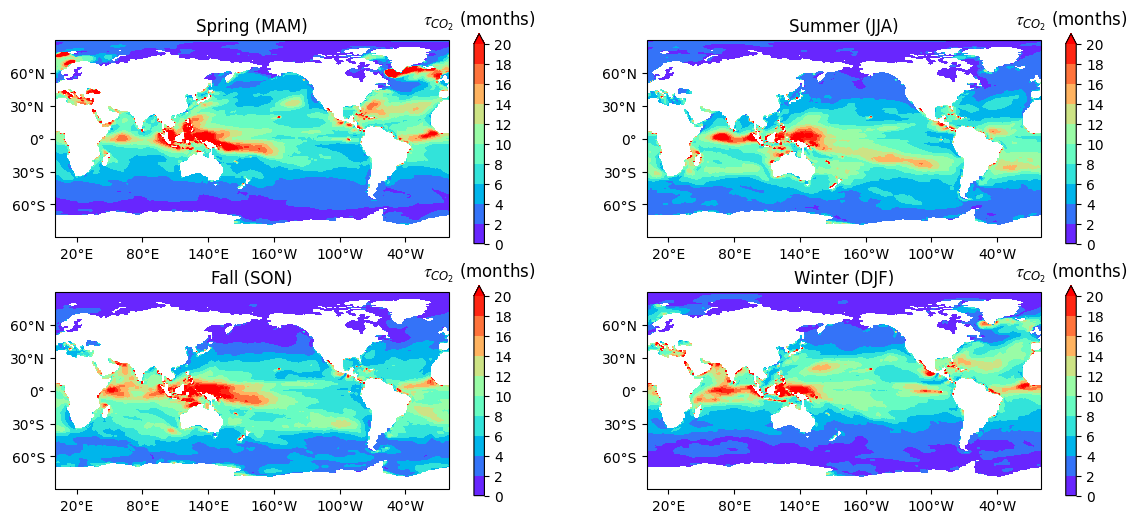

In [50]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(2,2,1, projection=ccrs.PlateCarree(central_longitude=180))
ax1 = plt.subplot(2,2,2, projection=ccrs.PlateCarree(central_longitude=180))
ax2 = plt.subplot(2,2,3, projection=ccrs.PlateCarree(central_longitude=180))
ax3 = plt.subplot(2,2,4, projection=ccrs.PlateCarree(central_longitude=180))

lon_min = 0
lon_max = 360
lat_min = -90
lat_max = 90

def modify(ax):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

    #ax.add_feature(cfeature.LAND, edgecolor='black')
    
modify(ax)
modify(ax1)
modify(ax2)
modify(ax3)

custom_colorbar_ticks = np.linspace(0,20,11)
sca = ax.contourf(ds_.TLONG, ds_.TLAT, tau_gas_exact_smean_.isel(season=2).tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

sca1 = ax1.contourf(ds_.TLONG, ds_.TLAT, tau_gas_exact_smean_.isel(season=1).tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );
sca2 = ax2.contourf(ds_.TLONG, ds_.TLAT, tau_gas_exact_smean_.isel(season=3).tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );
sca3 = ax3.contourf(ds_.TLONG, ds_.TLAT, tau_gas_exact_smean_.isel(season=0).tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

def add_cbar(sca, ax, custom_colorbar_ticks):
    custom_colorbar_labels  = [str(int(num)) for num in custom_colorbar_ticks]
    cb = fig.colorbar(sca, ax=ax, shrink=1)
    cb.ax.set_title('$𝜏_{CO_2}$ (months)')
    cb.set_ticks(custom_colorbar_ticks)
    cb.set_ticklabels(custom_colorbar_labels)

add_cbar(sca, ax, custom_colorbar_ticks)
add_cbar(sca1, ax1, custom_colorbar_ticks)
add_cbar(sca2, ax2, custom_colorbar_ticks)
add_cbar(sca3, ax3, custom_colorbar_ticks)
ax.set_title('Spring (MAM)')
ax1.set_title('Summer (JJA)')
ax2.set_title('Fall (SON)')
ax3.set_title('Winter (DJF)')



#### Seasonal mean from release month to release month+2

In [51]:
def get_3months_mean(start_mth):

    talk_smean = talk.isel(time=slice(start_mth,start_mth+3)).mean(dim='time').values
    tco2_smean = tco2.isel(time=slice(start_mth,start_mth+3)).mean(dim='time').values
    salinity_smean = salinity.isel(time=slice(start_mth,start_mth+3)).mean(dim='time').values
    theta_smean = theta.isel(time=slice(start_mth,start_mth+3)).mean(dim='time').values

    dDIC = 0.1
    csys = cal_dDICdCO2(talk_smean, tco2_smean, salinity_smean, theta_smean)
    csys_plus = cal_dDICdCO2(talk_smean, tco2_smean+dDIC, salinity_smean, theta_smean)
    dCO2 = np.array(csys_plus['CO2out']) - np.array(csys['CO2out'])
    dDICdCO2 =  dDIC/dCO2
    dDICdCO2 = dDICdCO2.reshape(tco2_smean.shape)
    
    hblt_sel_smean = hblt_sel_.HBLT.isel(time=slice(start_mth,start_mth+3)).mean(dim='time')
    ds_surf_smean = ds_surf.ECOSYS_XKW.isel(time=slice(start_mth,start_mth+3)).mean(dim='time')

    tau_gas_exact_smean = dDICdCO2 * (hblt_sel_smean*1e-2) / (ds_surf_smean*1e-2) / 86400.0 # units days
    tau_gas_exact_smean.attrs['units'] = 'days'
    
    tau_gas_exact_smean = (tau_gas_exact_smean/30).to_dataset(name='tau_gas')
    tau_gas_exact_smean['TLAT'] = tau_gas_exact_mean.TLAT
    tau_gas_exact_smean['TLONG'] = tau_gas_exact_mean.TLONG

    tau_gas_exact_smean_ = util.pop_add_cyclic(tau_gas_exact_smean)
    
    return tau_gas_exact_smean_

In [52]:
Jan_3mth = get_3months_mean(0)
Apr_3mth = get_3months_mean(3)
Jul_3mth = get_3months_mean(6)
Oct_3mth = get_3months_mean(9)

Text(0.5, 1.0, 'Oct - Dec')

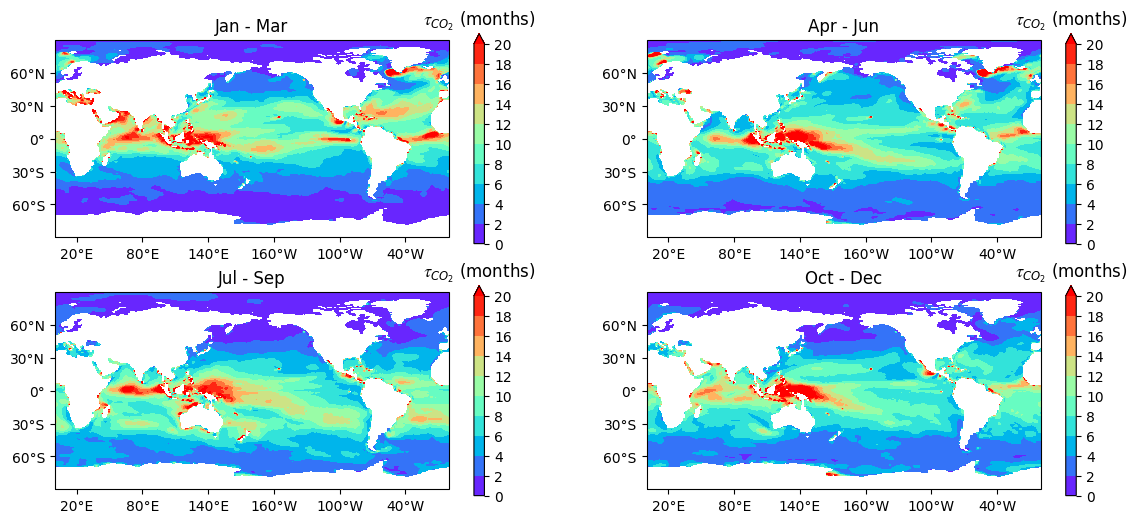

In [53]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(2,2,1, projection=ccrs.PlateCarree(central_longitude=180))
ax1 = plt.subplot(2,2,2, projection=ccrs.PlateCarree(central_longitude=180))
ax2 = plt.subplot(2,2,3, projection=ccrs.PlateCarree(central_longitude=180))
ax3 = plt.subplot(2,2,4, projection=ccrs.PlateCarree(central_longitude=180))

lon_min = 0
lon_max = 360
lat_min = -90
lat_max = 90

def modify(ax):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

    #ax.add_feature(cfeature.LAND, edgecolor='black')
    
modify(ax)
modify(ax1)
modify(ax2)
modify(ax3)

custom_colorbar_ticks = np.linspace(0,20,11)
sca = ax.contourf(ds_.TLONG, ds_.TLAT, Jan_3mth.tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

sca1 = ax1.contourf(ds_.TLONG, ds_.TLAT, Apr_3mth.tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );
sca2 = ax2.contourf(ds_.TLONG, ds_.TLAT, Jul_3mth.tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );
sca3 = ax3.contourf(ds_.TLONG, ds_.TLAT, Oct_3mth.tau_gas,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

def add_cbar(sca, ax, custom_colorbar_ticks):
    custom_colorbar_labels  = [str(int(num)) for num in custom_colorbar_ticks]
    cb = fig.colorbar(sca, ax=ax, shrink=1)
    cb.ax.set_title('$𝜏_{CO_2}$ (months)')
    cb.set_ticks(custom_colorbar_ticks)
    cb.set_ticklabels(custom_colorbar_labels)

add_cbar(sca, ax, custom_colorbar_ticks)
add_cbar(sca1, ax1, custom_colorbar_ticks)
add_cbar(sca2, ax2, custom_colorbar_ticks)
add_cbar(sca3, ax3, custom_colorbar_ticks)
ax.set_title('Jan - Mar')
ax1.set_title('Apr - Jun')
ax2.set_title('Jul - Sep')
ax3.set_title('Oct - Dec')

#### MLD

In [54]:
hblt_sel_smean = (hblt_sel_smean).to_dataset(name='HBLT')
hblt_sel_smean['TLAT'] = hblt_sel_smean.TLAT
hblt_sel_smean['TLONG'] = hblt_sel_smean.TLONG
hblt_sel_smean_ = util.pop_add_cyclic(hblt_sel_smean)

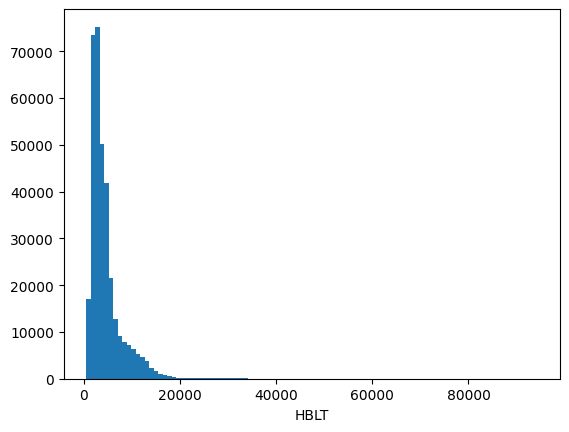

In [55]:
hblt_sel_smean_.HBLT.plot.hist(bins=100);

In [246]:
hblt_sel_smean_

<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 321, season: 4)
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT     (nlat, nlon) float64 nan nan nan nan ... 80.31 80.31 80.31 80.31
    TLONG    (nlat, nlon) float64 nan nan nan nan ... -39.0 -39.29 -39.57 -39.86
    HBLT     (season, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan

Text(0.5, 1.0, 'Winter (DJF)')

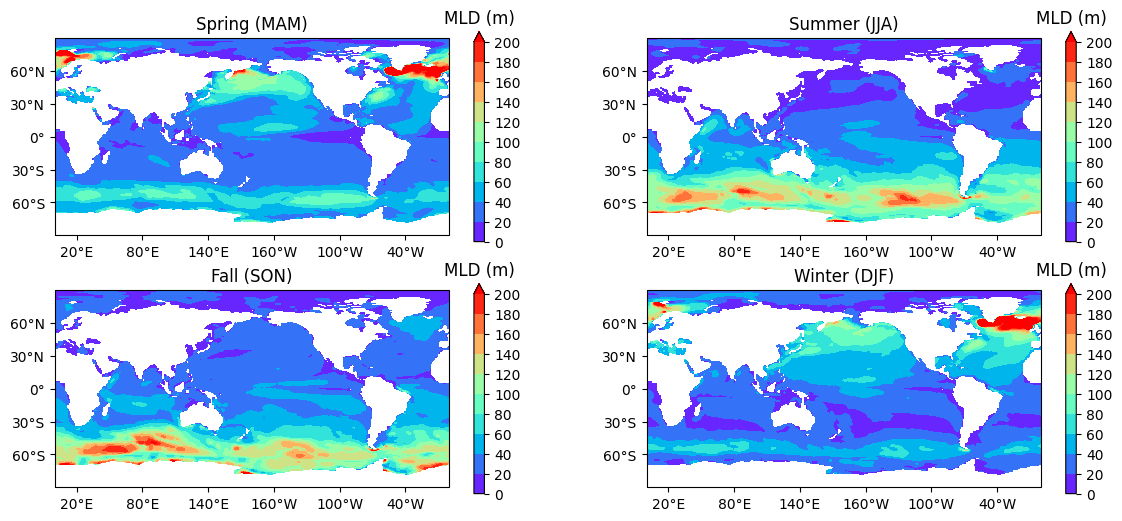

In [56]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(2,2,1, projection=ccrs.PlateCarree(central_longitude=180))
ax1 = plt.subplot(2,2,2, projection=ccrs.PlateCarree(central_longitude=180))
ax2 = plt.subplot(2,2,3, projection=ccrs.PlateCarree(central_longitude=180))
ax3 = plt.subplot(2,2,4, projection=ccrs.PlateCarree(central_longitude=180))

lon_min = 0
lon_max = 360
lat_min = -90
lat_max = 90

def modify(ax):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

    #ax.add_feature(cfeature.LAND, edgecolor='black')
    
modify(ax)
modify(ax1)
modify(ax2)
modify(ax3)

custom_colorbar_ticks = np.linspace(0,200,11)
sca = ax.contourf(ds_.TLONG, ds_.TLAT, hblt_sel_smean_.isel(season=2).HBLT/100,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

sca1 = ax1.contourf(ds_.TLONG, ds_.TLAT, hblt_sel_smean_.isel(season=1).HBLT/100,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );
sca2 = ax2.contourf(ds_.TLONG, ds_.TLAT, hblt_sel_smean_.isel(season=3).HBLT/100,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );
sca3 = ax3.contourf(ds_.TLONG, ds_.TLAT, hblt_sel_smean_.isel(season=0).HBLT/100,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

def add_cbar(sca, ax, custom_colorbar_ticks):
    custom_colorbar_labels  = [str(int(num)) for num in custom_colorbar_ticks]
    cb = fig.colorbar(sca, ax=ax, shrink=1)
    cb.ax.set_title('MLD (m)')
    cb.set_ticks(custom_colorbar_ticks)
    cb.set_ticklabels(custom_colorbar_labels)

add_cbar(sca, ax, custom_colorbar_ticks)
add_cbar(sca1, ax1, custom_colorbar_ticks)
add_cbar(sca2, ax2, custom_colorbar_ticks)
add_cbar(sca3, ax3, custom_colorbar_ticks)
ax.set_title('Spring (MAM)')
ax1.set_title('Summer (JJA)')
ax2.set_title('Fall (SON)')
ax3.set_title('Winter (DJF)')



In [57]:
def get_3months_mean(start_mth):

    hblt_sel_smean = hblt_sel_.HBLT.isel(time=slice(start_mth,start_mth+3)).mean(dim='time')
    ds_surf_smean = ds_surf.ECOSYS_XKW.isel(time=slice(start_mth,start_mth+3)).mean(dim='time')
    
    hblt_sel_smean['TLAT'] = tau_gas_exact_mean.TLAT
    hblt_sel_smean['TLONG'] = tau_gas_exact_mean.TLONG
    ds_surf_smean['TLAT'] = tau_gas_exact_mean.TLAT
    ds_surf_smean['TLONG'] = tau_gas_exact_mean.TLONG
    
    hblt_sel_smean = hblt_sel_smean.to_dataset(name='HBLT')
    ds_surf_smean = ds_surf_smean.to_dataset(name='ECOSYS_XKW')

    hblt_sel_smean_ = util.pop_add_cyclic(hblt_sel_smean)
    ds_surf_smean_ = util.pop_add_cyclic(ds_surf_smean)

    return hblt_sel_smean_, ds_surf_smean_

In [58]:
Jan_3mth_mld, Jan_3mth_xkw = get_3months_mean(0)
Apr_3mth_mld, Apr_3mth_xkw = get_3months_mean(3)
Jul_3mth_mld, Jul_3mth_xkw = get_3months_mean(6)
Oct_3mth_mld, Oct_3mth_xkw = get_3months_mean(9)

Text(0.5, 1.0, 'Oct - Dec')

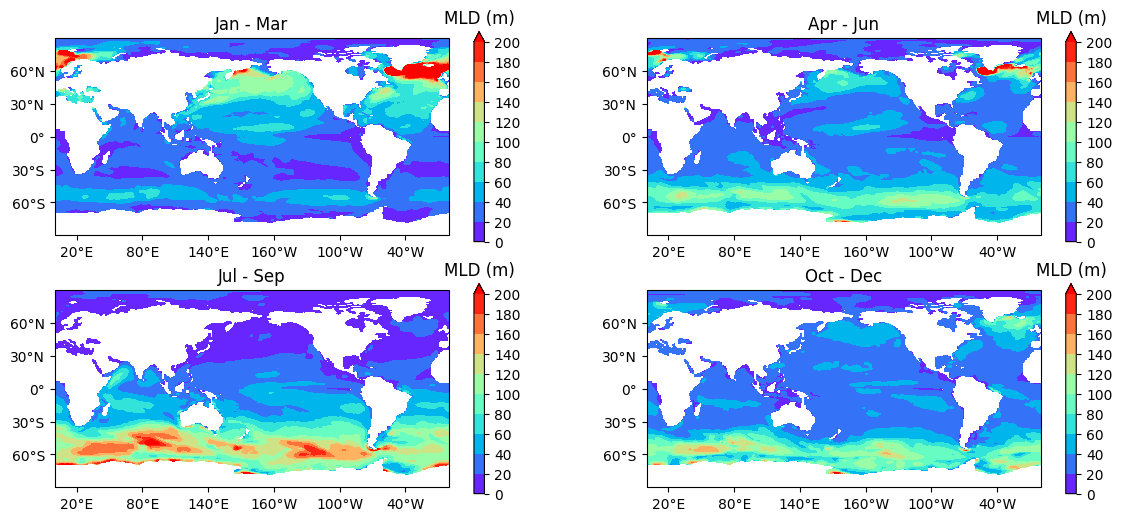

In [59]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(2,2,1, projection=ccrs.PlateCarree(central_longitude=180))
ax1 = plt.subplot(2,2,2, projection=ccrs.PlateCarree(central_longitude=180))
ax2 = plt.subplot(2,2,3, projection=ccrs.PlateCarree(central_longitude=180))
ax3 = plt.subplot(2,2,4, projection=ccrs.PlateCarree(central_longitude=180))

lon_min = 0
lon_max = 360
lat_min = -90
lat_max = 90

def modify(ax):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(lon_min+20, lon_max, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange( lat_min+30, lat_max, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 

    #ax.add_feature(cfeature.LAND, edgecolor='black')
    
modify(ax)
modify(ax1)
modify(ax2)
modify(ax3)

custom_colorbar_ticks = np.linspace(0,200,11)
sca = ax.contourf(ds_.TLONG, ds_.TLAT, Jan_3mth_mld.HBLT/100,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

sca1 = ax1.contourf(ds_.TLONG, ds_.TLAT, Apr_3mth_mld.HBLT/100,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );
sca2 = ax2.contourf(ds_.TLONG, ds_.TLAT, Jul_3mth_mld.HBLT/100,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );
sca3 = ax3.contourf(ds_.TLONG, ds_.TLAT, Oct_3mth_mld.HBLT/100,
                  transform=ccrs.PlateCarree(),
                  cmap=plt.cm.rainbow,

                  levels = custom_colorbar_ticks,
                  extend='max',
                 );

def add_cbar(sca, ax, custom_colorbar_ticks):
    custom_colorbar_labels  = [str(int(num)) for num in custom_colorbar_ticks]
    cb = fig.colorbar(sca, ax=ax, shrink=1)
    cb.ax.set_title('MLD (m)')
    cb.set_ticks(custom_colorbar_ticks)
    cb.set_ticklabels(custom_colorbar_labels)

add_cbar(sca, ax, custom_colorbar_ticks)
add_cbar(sca1, ax1, custom_colorbar_ticks)
add_cbar(sca2, ax2, custom_colorbar_ticks)
add_cbar(sca3, ax3, custom_colorbar_ticks)
ax.set_title('Jan - Mar')
ax1.set_title('Apr - Jun')
ax2.set_title('Jul - Sep')
ax3.set_title('Oct - Dec')

(array([8.5570e+03, 2.2771e+04, 2.4859e+04, 1.2871e+04, 7.5570e+03,
        7.0840e+03, 2.3420e+03, 2.4500e+02, 4.9000e+01, 1.2000e+01]),
 array([ 0.20018898,  1.62612822,  3.05206745,  4.47800669,  5.90394593,
         7.32988516,  8.7558244 , 10.18176364, 11.60770287, 13.03364211,
        14.45958135]),
 <BarContainer object of 10 artists>)

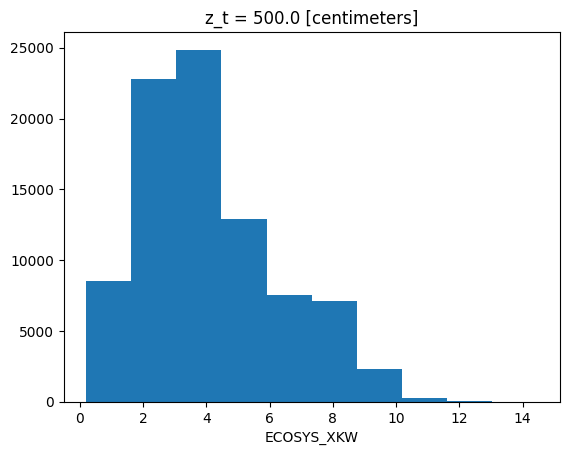

In [323]:
(Jan_3mth_xkw.ECOSYS_XKW/100*86400).plot.hist()